# Logistic Regression

Linear Regression works well when the dependent variable, i.e., our label, is numeric. When we have CATGORICAL or BINARY variable as the dependent variable, logistic regression is the way to go.

In this lab, we will be using the Titanic data from Kaggle to predict the survival of the passengers onboard. Please download the data set directly from our canvas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Please download the data set and save in your working folder
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Using this data set, let's review, yet again, the basics of data cleansing and data visualization

## Missing Data

We can use seaborn to create a simple heatmap to detect missing data

In [4]:
# First, use the "isnull()" method to conveniently locate the null values...
train.isnull()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


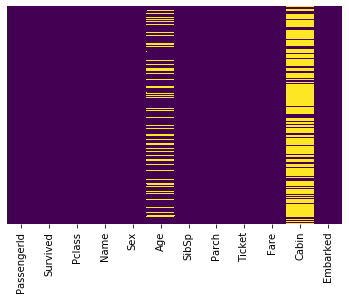

In [5]:
# However, it is not very friendly to the eyes...
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

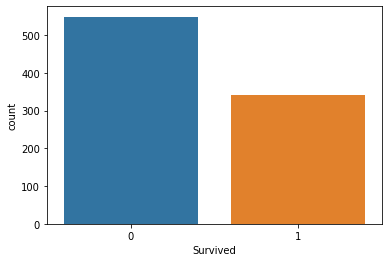

In [6]:
# A simple barchart
sns.countplot(x='Survived',data=train)

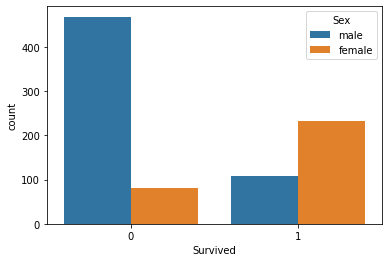

In [7]:
# Adding in an dimension using color...
sns.countplot(x='Survived',hue='Sex',data=train)

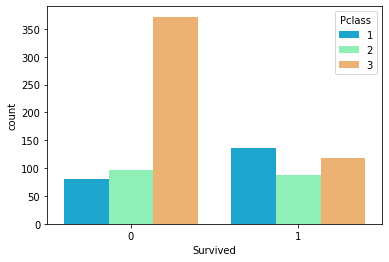

In [8]:
# Now let's analyze class vs. survival
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

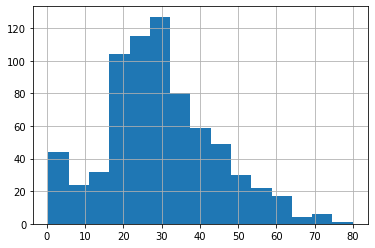

In [14]:
# Histogram, Pandas' way
train['Age'].hist(bins=15)


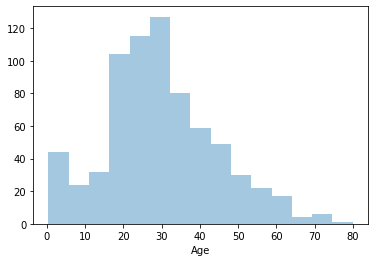

In [15]:
sns.distplot(train['Age'].dropna(),kde=False,bins=15)

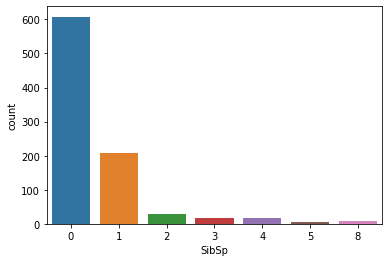

In [16]:
sns.countplot(x='SibSp',data=train)

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


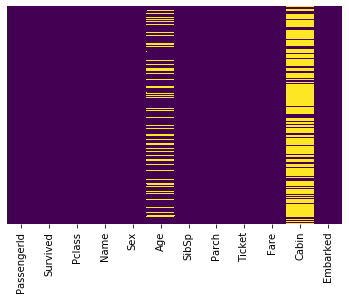

In [17]:
# Remember the missing values? We want to fill in missing age data instead of just dropping the missing age data rows. Instead 
# of filling every cell with the same value, let's look at the average age for different classes
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

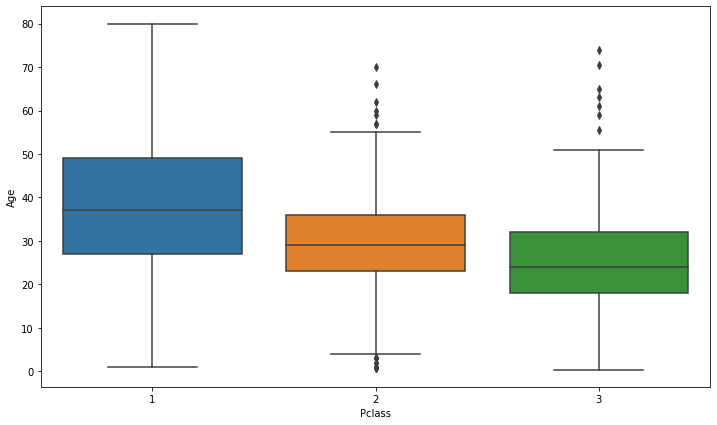

In [18]:
# Boxplot is perfect for showing the distribution of values in different categories
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train)

We'll use these average age values to impute based on Pclass for Age.

In [19]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [20]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

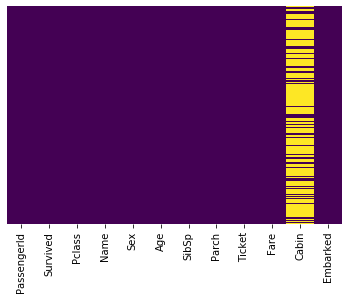

In [21]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

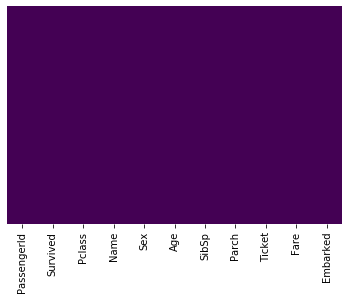

In [22]:
#Now we will drop the Cabin column
train.drop('Cabin',axis=1,inplace=True)
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Making Dummy Variables

We'll need to convert categorical features to dummy variables using pandas! 

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [26]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [27]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [28]:
train = pd.concat([train,sex,embark],axis=1)

In [29]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1




# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set 


In [30]:
from sklearn.model_selection import train_test_split
x = train.drop('Survived',axis=1)
y = train['Survived']


In [31]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.30)

## Training and Predicting

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
logmodel = LogisticRegression()
logmodel.fit(x_train,y_train)

C:\Users\llin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = logmodel.predict(x_test)

We can check precision,recall,f1-score using classification report!

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,predictions))